In [67]:
from deepBreaks.preprocessing import read_data
import pandas as pd

EpitestFileName = f"epistasis_full_test_results_xgb.csv"

WdstestFileName = f"wds_itr_test_results.csv"
WTtestFileName = f"wt_all_muts_pred_results.csv"

epi_test = read_data(EpitestFileName, seq_type = None, is_main=False)
wds_test = read_data(WdstestFileName, seq_type = None, is_main=False)
wt_test = read_data(WTtestFileName, seq_type = None, is_main=False)

In [50]:
epi_acc_list = epi_test.Accession.to_list()

epi_test = epi_test.set_index(epi_test['Accession'])
epi_test = epi_test.drop(columns='Accession')

wds_test = wds_test.set_index(wds_test['Accession'])
wds_test = wds_test.drop(columns='Accession')
wds_test = wds_test.loc[epi_acc_list]

wt_test = wt_test.set_index(wt_test['Accession'])
wt_test = wt_test.drop(columns='Accession')
wt_test = wt_test.loc[epi_acc_list]

In [51]:
epi_test['Sqr_Err'] = epi_test['Difference']**2
wds_test['Sqr_Err'] = wds_test['Difference']**2
wt_test['Sqr_Err'] = wt_test['Difference']**2

epi_test = epi_test.sort_values('Accession')
wds_test = wds_test.sort_values('Accession')
wt_test = wt_test.sort_values('Accession')

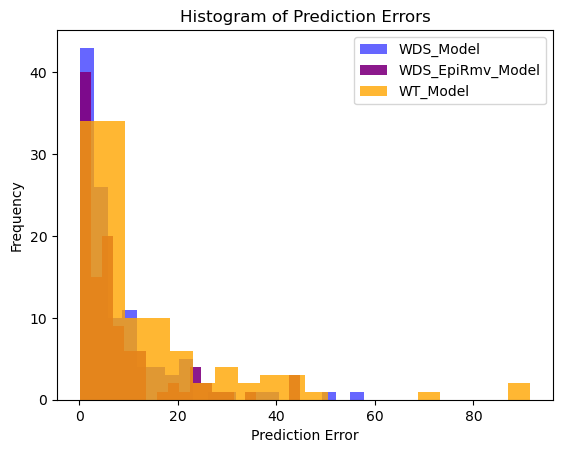

In [38]:

import matplotlib.pyplot as plt
import scipy.stats as st
# ... (your existing code to calculate errors_model1 and errors_model2)

# Histogram
plt.hist(abs(wds_test['Difference']), bins=20, alpha=0.6, label='WDS_Model', color='blue')
plt.hist(abs(epi_test['Difference']), bins=20, alpha=0.9, label='WDS_EpiRmv_Model', color='purple')
plt.hist(abs(wt_test['Difference']), bins=20, alpha=0.8, label='WT_Model', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Prediction Errors')
plt.show()

In [39]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. WT]")

statistic, p_value = st.wilcoxon(wds_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on ALL Mutant Data
Wilcoxon Test: Statistic = 1523.0 p-value = 9.488099012356298e-07 

Median of WDS-Model Square-Error = 21.5nm
Mean of WDS-Model Square-Error (MSE) = 156.0 // Root Mean Square Error (RMSE) = 12.5nm

Median of WT-Model Square-Error = 53.6nm
Mean of WDS-Model Square-Error (MSE) = 441.0 // Root Mean Square Error (RMSE) = 21.0nm


In [45]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wds_test['Sqr_Err'], alternative='two-sided')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WDS-Model Square-Error = {statistics.median(wds_test['Sqr_Err']):.1f}nm\nMean of WDS-Model Square-Error (MSE) = {statistics.mean(wds_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wds_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WDS vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 3076.0 p-value = 0.7983560716613722 

Median of WDS-Model Square-Error = 21.5nm
Mean of WDS-Model Square-Error (MSE) = 156.0 // Root Mean Square Error (RMSE) = 12.5nm

Median of EpiRmv-WDS-Model Square-Error = 21.6nm
Mean of EpiRmv-Model Square-Error (MSE) = 149.3 // Root Mean Square Error (RMSE) = 12.2nm


In [48]:
import scipy.stats as st
import statistics

# Perform Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
print("Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]")

statistic, p_value = st.wilcoxon(epi_test['Sqr_Err'], wt_test['Sqr_Err'], alternative='less')
print("Wilcoxon Test: Statistic =", statistic, "p-value =", p_value, "\n")

print(f"Median of WT-Model Square-Error = {statistics.median(wt_test['Sqr_Err']):.1f}nm\nMean of WT-Model Square-Error (MSE) = {statistics.mean(wt_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(wt_test['Sqr_Err'])):.1f}nm\n")
print(f"Median of EpiRmv-WDS-Model Square-Error = {statistics.median(epi_test['Sqr_Err']):.1f}nm\nMean of EpiRmv-Model Square-Error (MSE) = {statistics.mean(epi_test['Sqr_Err']):.1f} // Root Mean Square Error (RMSE) = {statistics.sqrt(statistics.mean(epi_test['Sqr_Err'])):.1f}nm")

Wilcoxn Signed-Rank Test on Epistasic Mutant Data [WT vs. EpiRmv-WDS]
Wilcoxon Test: Statistic = 1558.0 p-value = 1.5625403684790498e-06 

Median of WT-Model Square-Error = 53.6nm
Mean of WT-Model Square-Error (MSE) = 441.0 // Root Mean Square Error (RMSE) = 21.0nm

Median of EpiRmv-WDS-Model Square-Error = 21.6nm
Mean of EpiRmv-Model Square-Error (MSE) = 149.3 // Root Mean Square Error (RMSE) = 12.2nm


In [74]:
epi_test = epi_test[abs(epi_test['Difference']) <= 1]
epi_test.shape

(18, 16)

In [69]:
epi_test.head()

,Species,Phylum,Opsin_Family,Accession,Mutations,Lambda_Max,Prediction,Difference,WT_Lmax,Abs_Diff,Pred_Shift,additive_exp_shift,Shift_Diff,Colors,EdgeColors,mutant_type
S195,Danio_rerio,Chordata,Rh2,AB087805.2_L46F_I49C_S94T_V111A_M112I,"L46F, I49C, S94T, V111A, M112I",472.0,470.089761,1.910239,467,5.0,3.089761,9,5.910239,#f0f0f0,#c9c9c9,Multiple Mutations
S194,Danio_rerio,Chordata,Rh2,AB087805.2_S94T_V111A_M112I,"S94T, V111A, M112I",471.0,470.583981,0.416019,467,4.0,3.583981,2,1.583981,#f0f0f0,#c9c9c9,Multiple Mutations
S823,Anolis_carolinensis,Chordata,SWS2,AF133907_I46F_V49I_G164A,"I46F,V49I,G164A",438.0,438.987588,-0.987588,437,1.0,1.987588,5,3.012412,#f0f0f0,#c9c9c9,Multiple Mutations
S1030,Homo_sapiens,Chordata,LWS,"AH005296.2_A180S,A285T","A180S,A285T",546.0,547.751909,-1.751909,532,14.0,15.751909,12,3.751909,#f0f0f0,#762a83,Multiple Mutations
S1008,Homo_sapiens,Chordata,LWS,"AH005296.2_A180S,F277Y,A285T","A180S,F277Y,A285T",555.0,556.467417,-1.467416,532,23.0,24.467416,18,6.467416,#f0f0f0,#762a83,Multiple Mutations


In [70]:
epi_test = epi_test[abs(epi_test['Shift_Diff']) > 1]
epi_test.shape

(55, 16)

In [76]:
epi_test.head()

,Species,Phylum,Opsin_Family,Accession,Mutations,Lambda_Max,Prediction,Difference,WT_Lmax,Abs_Diff,Pred_Shift,additive_exp_shift,Shift_Diff,Colors,EdgeColors,mutant_type
S194,Danio_rerio,Chordata,Rh2,AB087805.2_S94T_V111A_M112I,"S94T, V111A, M112I",471.0,470.583981,0.416019,467,4.0,3.583981,2,1.583981,#f0f0f0,#c9c9c9,Multiple Mutations
S823,Anolis_carolinensis,Chordata,SWS2,AF133907_I46F_V49I_G164A,"I46F,V49I,G164A",438.0,438.987588,-0.987588,437,1.0,1.987588,5,3.012412,#f0f0f0,#c9c9c9,Multiple Mutations
S1019,Homo_sapiens,Chordata,LWS,"AH005296.2_A180S,T230I,F277Y,A285T,F309Y","A180S,T230I,F277Y,A285T,F309Y",558.0,558.914701,-0.914701,532,26.0,26.914701,18,8.914701,#f0f0f0,#762a83,Multiple Mutations
S1018,Homo_sapiens,Chordata,LWS,"AH005296.2_A180S,T230I,S233A,F277Y,A285T,F309Y","A180S,T230I,S233A,F277Y,A285T,F309Y",560.0,559.077834,0.922166,532,28.0,27.077834,19,8.077834,#f0f0f0,#762a83,Multiple Mutations
S1031,Homo_sapiens,Chordata,LWS,"AH005296.2_F277Y,A285T","F277Y,A285T",550.0,550.736699,-0.736699,532,18.0,18.736699,16,2.736699,#f0f0f0,#762a83,Multiple Mutations


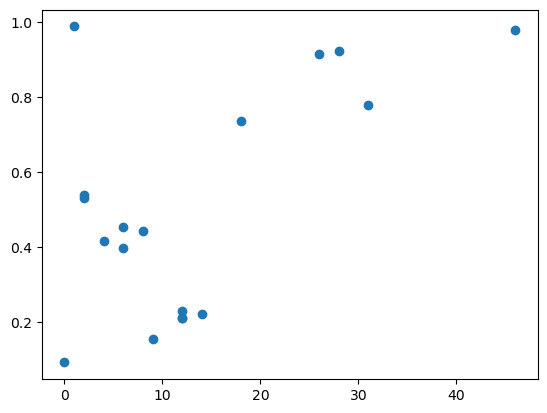

In [75]:
plt.scatter(epi_test['Abs_Diff'], abs(epi_test['Difference']))
